In [1]:
import nltk
nltk.download('stopwords')

from importlib.metadata import version
import nltk
import tensorflow
import summa
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Overview
Project start date: Oct 9, 2023  
Goal: Summarizing news articles  
Main points :  
 - Create an LSTM model and apply the Attention mechanism to the decoder for abstractive summarization.  
 - Monitor the loss values (both during training and validation) and the prediction results.  
 - Evaluate the predictions using the Summa package for extractive summarization.  
 - Discuss the pros and cons of each summarization method.

# 1. Exploratory Data Analysis
Github link of source data : https://github.com/sunnysai12345/News_Summary  
The dataset consists of 4515 examples and contains Author_name, Headlines, Url of Article, Short text, Complete Article. According to the Readme file, summarized news from Inshorts and only scraped the news articles from Hindu, Indian times and Guardian.  
  
I will use 'headlines', and 'Complete' on this project.

## 1-1. Retrieve Data

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summarization/data/news_summary_more.csv")
data = pd.read_csv('news_summarization/data/news_summary_more.csv', encoding='iso-8859-1')

In [4]:
print('The number of data:', len(data))
data.head()

The number of data: 98401


,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


## 1-2. Delete duplicated data

In [5]:
# The number of explicitly duplicated data
print('The number of data in "headlines" excluding duplicates : ', data['headlines'].nunique())
print('The number of data in "text" excluding duplicates : ', data['text'].nunique())

The number of data in "headlines" excluding duplicates :  98280
The number of data in "text" excluding duplicates :  98360


In [6]:
# Delete duplicated data
data.drop_duplicates(subset = ['text'], inplace = True)

## 1-3. Delete NaN data

In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


## 1-4. Text normalization

### 1-4-1. Define contractions

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("The number of contractions dictionary: ", len(contractions))

The number of contractions dictionary:  120


### 1-4-2. Define preprocessing function

In [9]:
# Data preprocessing function
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()  # Convert text to lowercase
    sentence = BeautifulSoup(sentence, "lxml").text  # Remove HTML tags like <br />, <a href = ...>
    sentence = re.sub(r'\([^)]*\)', '', sentence)  # Remove strings enclosed in parentheses (...)
    sentence = re.sub('"', '', sentence)  # Remove double quotation marks "
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])  # Normalize contractions (e.g., "don't" -> "do not")
    sentence = re.sub(r"'s\b", "", sentence)  # Remove possessive 's (e.g., "roland's" -> "roland")
    sentence = re.sub("[^a-zA-Z]", " ", sentence)  # Replace non-alphabet characters with whitespace
    sentence = re.sub('[m]{2,}', 'mm', sentence)  # Replace consecutive 'm' characters (3 or more) with 'mm' (e.g., "ummmmmmm yeah" -> "umm yeah")
    
    # Remove stopwords (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # Keep stopwords (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

## 1-5. Preprocess raw data

In [10]:
temp_textdata = [] 

for index, row in tqdm(data.iterrows(), total=data.shape[0]):
    sentence = row['text']
    temp = preprocess_sentence(sentence)
    temp_textdata.append(temp)
    
print("Text 전처리 후 결과: ", temp_textdata[:5])

100%|██████████| 98360/98360 [10:27<00:00, 156.72it/s]

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [11]:
temp_headlinesdata = []

for index, row in tqdm(data.iterrows(), total=data.shape[0]):
    sentence = row['headlines']
    temp = preprocess_sentence(sentence)
    temp_headlinesdata.append(temp)
    
print("Headline 전처리 후 결과: ", temp_headlinesdata[:5])

100%|██████████| 98360/98360 [02:19<00:00, 706.33it/s]

Headline 전처리 후 결과:  ['upgrad learner switches career ml al salary hike', 'delhi techie wins free food swiggy one year cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'known hirani yrs metoo claims true sonam']


In [12]:
data['text'] = temp_textdata
data['headlines'] = temp_headlinesdata

# Replace '' to np.nan
data.replace('', np.nan, inplace=True)

In [13]:
# Check null value
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 1-5-1. Visulaization preprocessing result

min of text : 1
max of text : 60
avg of text : 35.09968483123221
std dev of text : 3.7993861876499637
min of headlines : 1
max of headlines : 13
avg of headlines : 7.136183407889386
std dev of text : 1.1624147471716224


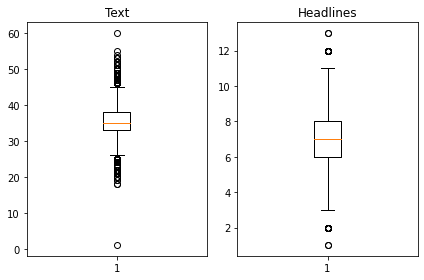

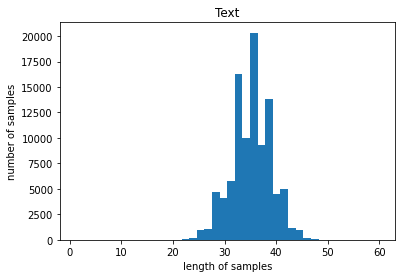

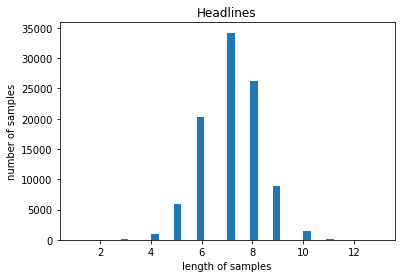

In [14]:
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('min of text : {}'.format(np.min(text_len)))
print('max of text : {}'.format(np.max(text_len)))
print('avg of text : {}'.format(np.mean(text_len)))
print('std dev of text : {}'.format(np.std(text_len)))
print('min of headlines : {}'.format(np.min(headlines_len)))
print('max of headlines : {}'.format(np.max(headlines_len)))
print('avg of headlines : {}'.format(np.mean(headlines_len)))
print('std dev of text : {}'.format(np.std(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 1-5-2. Configure max len of data

In [15]:
def print_proportion_below_threshold_len(max_len, nested_list):
    count = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            count += 1
    print('Proportion of samples with a length of %s or less among all samples: %s' % (max_len, (count / len(nested_list))))

In [16]:
text_max_len = 42
headline_max_len = 9

print_proportion_below_threshold_len(text_max_len, data['text'])
print_proportion_below_threshold_len(headline_max_len,  data['headlines'])

Proportion of samples with a length of 42 or less among all samples: 0.9750305002033347
Proportion of samples with a length of 9 or less among all samples: 0.9826250508336722


In [17]:
data = data[data.apply(lambda row: len(row['text'].split()) <= text_max_len 
                       and len(row['headlines'].split()) <= headline_max_len, axis = 1)]
print("Total number of data after configuring max len of data: ",len(data))

Total number of data after configuring max len of data:  94367


In [18]:
# copy data just in case
temp_data = data.copy()

## 1-6. Create decoder dataset

In [19]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')

data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken
5,rahat fateh ali khan denies getting notice smu...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice smu...
6,india get lowest odi total new zealand,india recorded lowest odi total new zealand ge...,sostoken india get lowest odi total new zealand,india get lowest odi total new zealand eostoken


## 1-7. Devide data to train and test data

In [20]:
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

### 1-7-1. Suffle dataset
We should suffle dataset before applying it to the model, and it is a common practice in machine learning.  
The reesona of suffling:  
 - Enhancing Generalization: Reducing Overfitting  
 - Ensuring Randomness  

In [21]:
# Suffle dataset
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

### 1-7-2. Divide dataset

In [22]:
n_of_val = int(len(encoder_input)*0.3)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('Number of train_data :', len(encoder_input_train))
print('Number of train_label :', len(decoder_input_train))
print('Number of test_data :', len(encoder_input_test))
print('Number of test_label :', len(decoder_input_test))

Number of train_data : 66057
Number of train_label : 66057
Number of test_data : 28310
Number of test_label : 28310


## 1-8. Preprocessing devieded encoding & decoding train data

### 1-8-1. Delete rare data

In [23]:
# Function for checking the propotion of rara data
def print_info_of_raredata (threshold, tokenizer):
    total_cnt = len(tokenizer.word_index)  # Total number of words in the vocabulary
    rare_cnt = 0  # Count of words with frequency less than the threshold
    total_freq = 0  # Total frequency of words in the training data
    rare_freq = 0  # Total frequency of words with frequency less than the threshold

    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value
    
        if(value < threshold):
            rare_cnt += 1
            rare_freq += value
        

    print('Vocabulary size:', total_cnt)
    print('Number of rare words with a frequency of less than %s: %s' % (threshold - 1, rare_cnt))
    print('Vocabulary size when excluding rare words: %s' % (total_cnt - rare_cnt))
    print("Percentage of rare words in the vocabulary:", (rare_cnt / total_cnt) * 100)
    print("Percentage of total word frequency accounted for by rare words:", (rare_freq / total_freq) * 100)

In [25]:
src_tokenizer = Tokenizer()

# Create set of vocab in decoder_input_train
src_tokenizer.fit_on_texts(encoder_input_train)

In [26]:
print_info_of_raredata(threshold=7, tokenizer=src_tokenizer)

Vocabulary size: 64061
Number of rare words with a frequency of less than 6: 43840
Vocabulary size when excluding rare words: 20221
Percentage of rare words in the vocabulary: 68.4347731068825
Percentage of total word frequency accounted for by rare words: 3.875217315716273


In [27]:
# Delete rare words in input
src_vocab = 20221
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

In [28]:
tar_tokenizer = Tokenizer()

# Create set of vocab in decoder_input_train
tar_tokenizer.fit_on_texts(decoder_input_train)

In [29]:
print_info_of_raredata(threshold=7, tokenizer=tar_tokenizer)

Vocabulary size: 27870
Number of rare words with a frequency of less than 6: 19364
Vocabulary size when excluding rare words: 8506
Percentage of rare words in the vocabulary: 69.47972730534624
Percentage of total word frequency accounted for by rare words: 7.5629180551049835


In [30]:
# Delete rare words in output
tar_vocab = 8506
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

### 1-8-2. Convert text to int

In [31]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [32]:
print(encoder_input_train[:3])

[[297, 741, 1041, 2, 104, 135, 15, 2338, 49, 1, 2754, 840, 1783, 104, 117, 1957, 336, 2338, 795, 2359, 3659, 4415, 600, 8, 26, 1, 126, 521, 324, 1395, 12, 5118], [422, 1995, 16, 9223, 7104, 8365, 591, 64, 62, 91, 1392, 2812, 370, 51, 12040, 8527, 7104, 65, 5119, 2374, 167, 397, 185, 11, 22, 379, 4171, 422, 1995, 591, 2260, 9889, 503, 3158, 8527, 51, 4603, 1392], [9649, 1207, 12041, 585, 14533, 17672, 2116, 5120, 3247, 1127, 189, 425, 575, 190, 3457, 3323, 2595, 2866, 891, 2279, 2116, 6021, 791, 315, 8056]]


In [33]:
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 3879, 33, 78, 2452, 531, 858, 2851], [1, 423, 784, 105, 477, 209, 707, 1063], [1, 6760, 532, 545, 171, 2923, 3086], [1, 1086, 1952, 3631, 715, 1993, 670], [1, 5, 7836, 12, 419, 442, 6340, 802, 452, 1064]]
target
decoder  [[3879, 33, 78, 2452, 531, 858, 2851, 2], [423, 784, 105, 477, 209, 707, 1063, 2], [6760, 532, 545, 171, 2923, 3086, 2], [1086, 1952, 3631, 715, 1993, 670, 2], [5, 7836, 12, 419, 442, 6340, 802, 452, 1064, 2]]


### 1-8-3. Delete empy data on target data (because of deleting rare word)

In [34]:
# Create index list consisting of sostoken and eostoken
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('Number of training data to be removed:', len(drop_train))
print('Number of test data to be removed:', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('Number of training data:', len(encoder_input_train))
print('Number of training labels:', len(decoder_input_train))
print('Number of test data:', len(encoder_input_test))
print('Number of test labels:', len(decoder_input_test))

Number of training data to be removed: 1
Number of test data to be removed: 2
Number of training data: 66056
Number of training labels: 66056
Number of test data: 28308
Number of test labels: 28308


### 1-8-4. Insert padding 

In [35]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='pre')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='pre')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headline_max_len, padding='pre')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headline_max_len, padding='pre')

# 2. Create, trian and test the Model

## 2-1. Create the Model
![img1](asset/img1.jpeg)
### 2-1-1. Create encoder

In [37]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 128
hidden_size = 256

encoder_inputs = Input(shape=(text_max_len,))

# Encoder's Embedding Layer
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# Encoder's LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Encoder's LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)  

# Encoder's LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

### 2-1-1. Create decoder

In [38]:
# Decoder Design
decoder_inputs = Input(shape=(None,))

# Decoder's Embedding Layer
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder's LSTM Layer
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

# Decoder's Output Layer
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# Model Definition
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 128)      2588288     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 42, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

Apply attention mechanism  
    ![img2](asset/img2.jpeg)

In [40]:
from tensorflow.keras.layers import AdditiveAttention

# Attention Layer (Attention Function)
attn_layer = AdditiveAttention(name='attention_layer')

# Pass the hidden states of all time steps from the encoder and decoder to the attention layer
attn_out = attn_layer([decoder_outputs, encoder_output3])

# Connect the output of the attention mechanism with the decoder's hidden states
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Decoder's Output Layer
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# Model Definition
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 128)      2588288     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 42, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 2-2. Train the Model

In [41]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
259/259 [==============================] - 57s 87ms/step - loss: 5.9570 - val_loss: 5.6313
Epoch 2/50
259/259 [==============================] - 21s 83ms/step - loss: 5.7444 - val_loss: 5.5584
Epoch 3/50
259/259 [==============================] - 22s 84ms/step - loss: 5.5797 - val_loss: 5.3476
Epoch 4/50
259/259 [==============================] - 22s 85ms/step - loss: 5.2831 - val_loss: 5.1798
Epoch 5/50
259/259 [==============================] - 22s 84ms/step - loss: 5.0313 - val_loss: 4.9653
Epoch 6/50
259/259 [==============================] - 22s 84ms/step - loss: 4.7895 - val_loss: 4.7822
Epoch 7/50
259/259 [==============================] - 22s 84ms/step - loss: 4.5774 - val_loss: 4.6291
Epoch 8/50
259/259 [==============================] - 22s 84ms/step - loss: 4.3944 - val_loss: 4.5485
Epoch 9/50
259/259 [==============================] - 22s 84ms/step - loss: 4.2345 - val_loss: 4.4244
Epoch 10/50
259/259 [==============================] - 22s 84ms/step - loss: 4.088

### 2-2-1. Visulaization the result

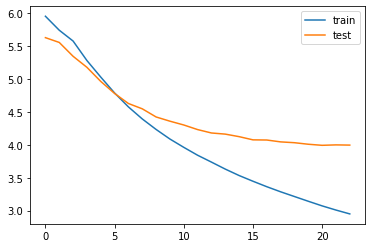

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 2-3. Test the Model
### 2-3-1.  Create the final step for coverting result of testing model

In [45]:
# Encoder design
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

# Tensors to store the previous time step states
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [46]:
# Attention Function
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Decoder's Output Layer
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# Final Decoder Model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [47]:
src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

def decode_sequence(input_seq):
    # Obtain the encoder's states from the input
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate the token for <SOS> (Start of Sentence)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:  # Continue the loop until stop_condition becomes True

        # Predict the next token in the sequence using the decoder model
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token

        # Stop when <eos> is reached or maximum length is exceeded
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (headline_max_len - 1):
            stop_condition = True

        # Update the target sequence with a length-1 token
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update the states
        e_h, e_c = h, c

    return decoded_sentence

In [48]:
# Convert the integer sequence of the original text to a text sequence
def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        if i != 0:
            temp = temp + src_index_to_word[i] + ' '
    return temp

# Convert the integer sequence of the summary to a text sequence
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if i == 1:
            temp = temp + ''
        elif i == 2:
            temp = temp + ''
        elif i != 0:
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [49]:
for i in range(50, 100):
    print("Original Text :", seq2text(encoder_input_test[i]))
    print("Actual Summary :", seq2summary(decoder_input_test[i]))
    print("Predicted Summary :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")


Original Text : talking ball tampering scandal banned australian cricketer steve smith said could stopped negative outcome happened middle witnessed planned dressing room said guys stop smith said failure leadership taken responsibility added 
Actual Summary : said stop smith ball tampering 
Predicted Summary :  smith slams australian captain ban smith warner ban


Original Text : year old man hyderabad monday surrendered police allegedly killing wife two children fit rage man reportedly lost job technician dental clinic depressed ever since killed wife reportedly kept matter mocked 
Actual Summary : hyd man surrenders cops murdering wife kids 
Predicted Summary :  man kills wife death jail killing wife


Original Text : five mobile phones recovered police gurugram jail since wednesday comes several complaints alleged criminals making extortion calls inside jail notably mobile phones sim cards recovered inmates jail day long search june year 
Actual Summary : mobile phones recovered gu

Predicted Summary :  akshay kumar make cr film industry industry films


Original Text : mumbai metropolitan region development authority officials said mumbai specific plan integrated ticketing system ready december system plans smart card modes public transport city including suburban railways best bus services monorail mumbai metro network 
Actual Summary : mumbai one city one ticket plan ready dec 
Predicted Summary :  mumbai civic body cuts buses electric car buses


Original Text : yuva sena chief thackeray asked brihanmumbai municipal corporation conduct feasibility study whether confiscated plastic used making roads public amenities thackeray proposal comes amid bmc ongoing efforts make markets plastic free many restaurants caf already committed use plastic straws bags said 
Actual Summary : sena chief proposes using plastic waste make roads 
Predicted Summary :  shiv sena asks delhi govt allow liquor service


Original Text : video showing actress priyanka chopra husband ameri

Predicted Summary :  kapil show kapil show tv show show show


Original Text : least people including journalists killed others injured twin suicide bombings afghan capital kabul according health ministry officials immediate claim responsibility attack earlier month suicide bomber blew outside voter registration centre kabul killing people 
Actual Summary : twin suicide afghanistan kill injure 
Predicted Summary :  suicide bombing bombing near air force kills iraq


Original Text : hyderabad traffic police arrested people drinking driving intervening night sunday monday police also seized cars bikes per reports filed offenders produced local magistrate court police official said 
Actual Summary : hyderabad police arrest drunk driving one night 
Predicted Summary :  two arrested stealing cars carrying car hiding noida


Original Text : batsman hanuma vihari become first andhra cricketer years picked india test squad year old right handed batsman first class average highest among contemp

# 3. Compare Extractive summary

In [53]:
import requests
from summa.summarizer import summarize

for i in range(50, 100):
    print("Original Text:", seq2text(encoder_input_test[i]))
    print("Actual Summary:", seq2summary(decoder_input_test[i]))
    print("Extractive Summary:", summarize(seq2text(encoder_input_test[i]), ratio=0.5))
    print("Abstractive Summary:", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")


Original Text: talking ball tampering scandal banned australian cricketer steve smith said could stopped negative outcome happened middle witnessed planned dressing room said guys stop smith said failure leadership taken responsibility added 
Actual Summary: said stop smith ball tampering 
Extractive Summary: 
Abstractive Summary:  smith slams australian captain ban smith warner ban


Original Text: year old man hyderabad monday surrendered police allegedly killing wife two children fit rage man reportedly lost job technician dental clinic depressed ever since killed wife reportedly kept matter mocked 
Actual Summary: hyd man surrenders cops murdering wife kids 
Extractive Summary: 
Abstractive Summary:  man kills wife death jail killing wife


Original Text: five mobile phones recovered police gurugram jail since wednesday comes several complaints alleged criminals making extortion calls inside jail notably mobile phones sim cards recovered inmates jail day long search june year 
Actu

Abstractive Summary:  us judge orders us asylum era abuse victims


Original Text: actor akshay kumar said south crore spent film publicity added reality shows many press meets like us release big films diwali akshay said new things seen cinema 
Actual Summary: cr spent film publicity south akshay 
Extractive Summary: 
Abstractive Summary:  akshay kumar make cr film industry industry films


Original Text: mumbai metropolitan region development authority officials said mumbai specific plan integrated ticketing system ready december system plans smart card modes public transport city including suburban railways best bus services monorail mumbai metro network 
Actual Summary: mumbai one city one ticket plan ready dec 
Extractive Summary: 
Abstractive Summary:  mumbai civic body cuts buses electric car buses


Original Text: yuva sena chief thackeray asked brihanmumbai municipal corporation conduct feasibility study whether confiscated plastic used making roads public amenities thackeray 

Abstractive Summary:  infosys ceo quits quits amid exit exit report


Original Text: india second odi world cup years april defeating sri lanka mumbai wankhede stadium win india became third country win world cup twice first win home soil captain ms dhoni man match last ball six 
Actual Summary: pictures india world cup victory 
Extractive Summary: 
Abstractive Summary:  india beat sl win world cup odi women


Original Text: th episode kapil sharma show comedian kapil sharma said would like thank audience celebrities show team including members currently feature show sunil grover ali asgar chandan prabhakar shot show kapil shouted sunil flight march 
Actual Summary: thank team even ones left show kapil 
Extractive Summary: 
Abstractive Summary:  kapil show kapil show tv show show show


Original Text: least people including journalists killed others injured twin suicide bombings afghan capital kabul according health ministry officials immediate claim responsibility attack earlier month